# <font color=006A80>Penguins Detector - YOLOv5</font>
#### <font color=006A80>*By Dr. Lihi Gur Arie*</font>
***

## <font color=2892A8>Installation</font>  

<font color=003762>
Place this notebook under the desired directory, choose PyTorch version that matchs your hardware from 
https://pytorch.org/ and install:

In [ ]:
!conda install pytorch torchvision cudatoolkit=11.3 -c pytorch

<font color=003762>Clone yolov5 repository from ultralytics:

In [ ]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5

<font color=003762>Install requirements:

In [ ]:
%pip install -qr requirements.txt  

<font color=003762>Import libraries:

In [1]:
%cd yolov5
import torch
from yolov5 import utils
import torch
import utils
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


%matplotlib inline
display = utils.notebook_init()

YOLOv5 🚀 v6.0-253-ga45e472 torch 1.10.2 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5947MiB)


Setup complete ✅ (8 CPUs, 31.0 GB RAM, 329.7/383.5 GB disk)


## <font color=2892A8>Data handeling</font>

<font color=003762>
1. Provide your dataset:

The following function will generate the data directories splited into train, val, test.

In [ ]:
def create_data_directories(data_name):
    Path(f"../datasets/{data_name}/images/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/images/test").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/train").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/valid").mkdir(parents=True, exist_ok=True)
    Path(f"../datasets/{data_name}/labels/test").mkdir(parents=True, exist_ok=True)

    
create_data_directories('Penguins_data')

<font color=003762>Place your data in the correct folders.

<font color=003762>
    2. Write 'data.yaml' file that suits your data: Make sure the paths to the data are correct. 
Make sure that the number of classes (nc) and the names of the classes match your data.
    

This is the content of my penguins_data.yaml file:

In [2]:
!cat data/penguins_data.yaml
print ('---------------------------------------------')



train: ../datasets/Penguins_data/images/train
val: ../datasets/Penguins_data/images/valid
test: ../datasets/Penguins_data/images/test

nc: 1
names: ['Penguin']
---------------------------------------------


## <font color=2892A8>Training</font>

### <font color=003762>Feature extraction

In [3]:
!python train.py --batch 32 --epochs 150 --data 'data/penguins_data.yaml' --weights 'yolov5s6.pt' --project 'runs_penguins' --name 'feature_extraction' --cache --freeze 12
clear_output()

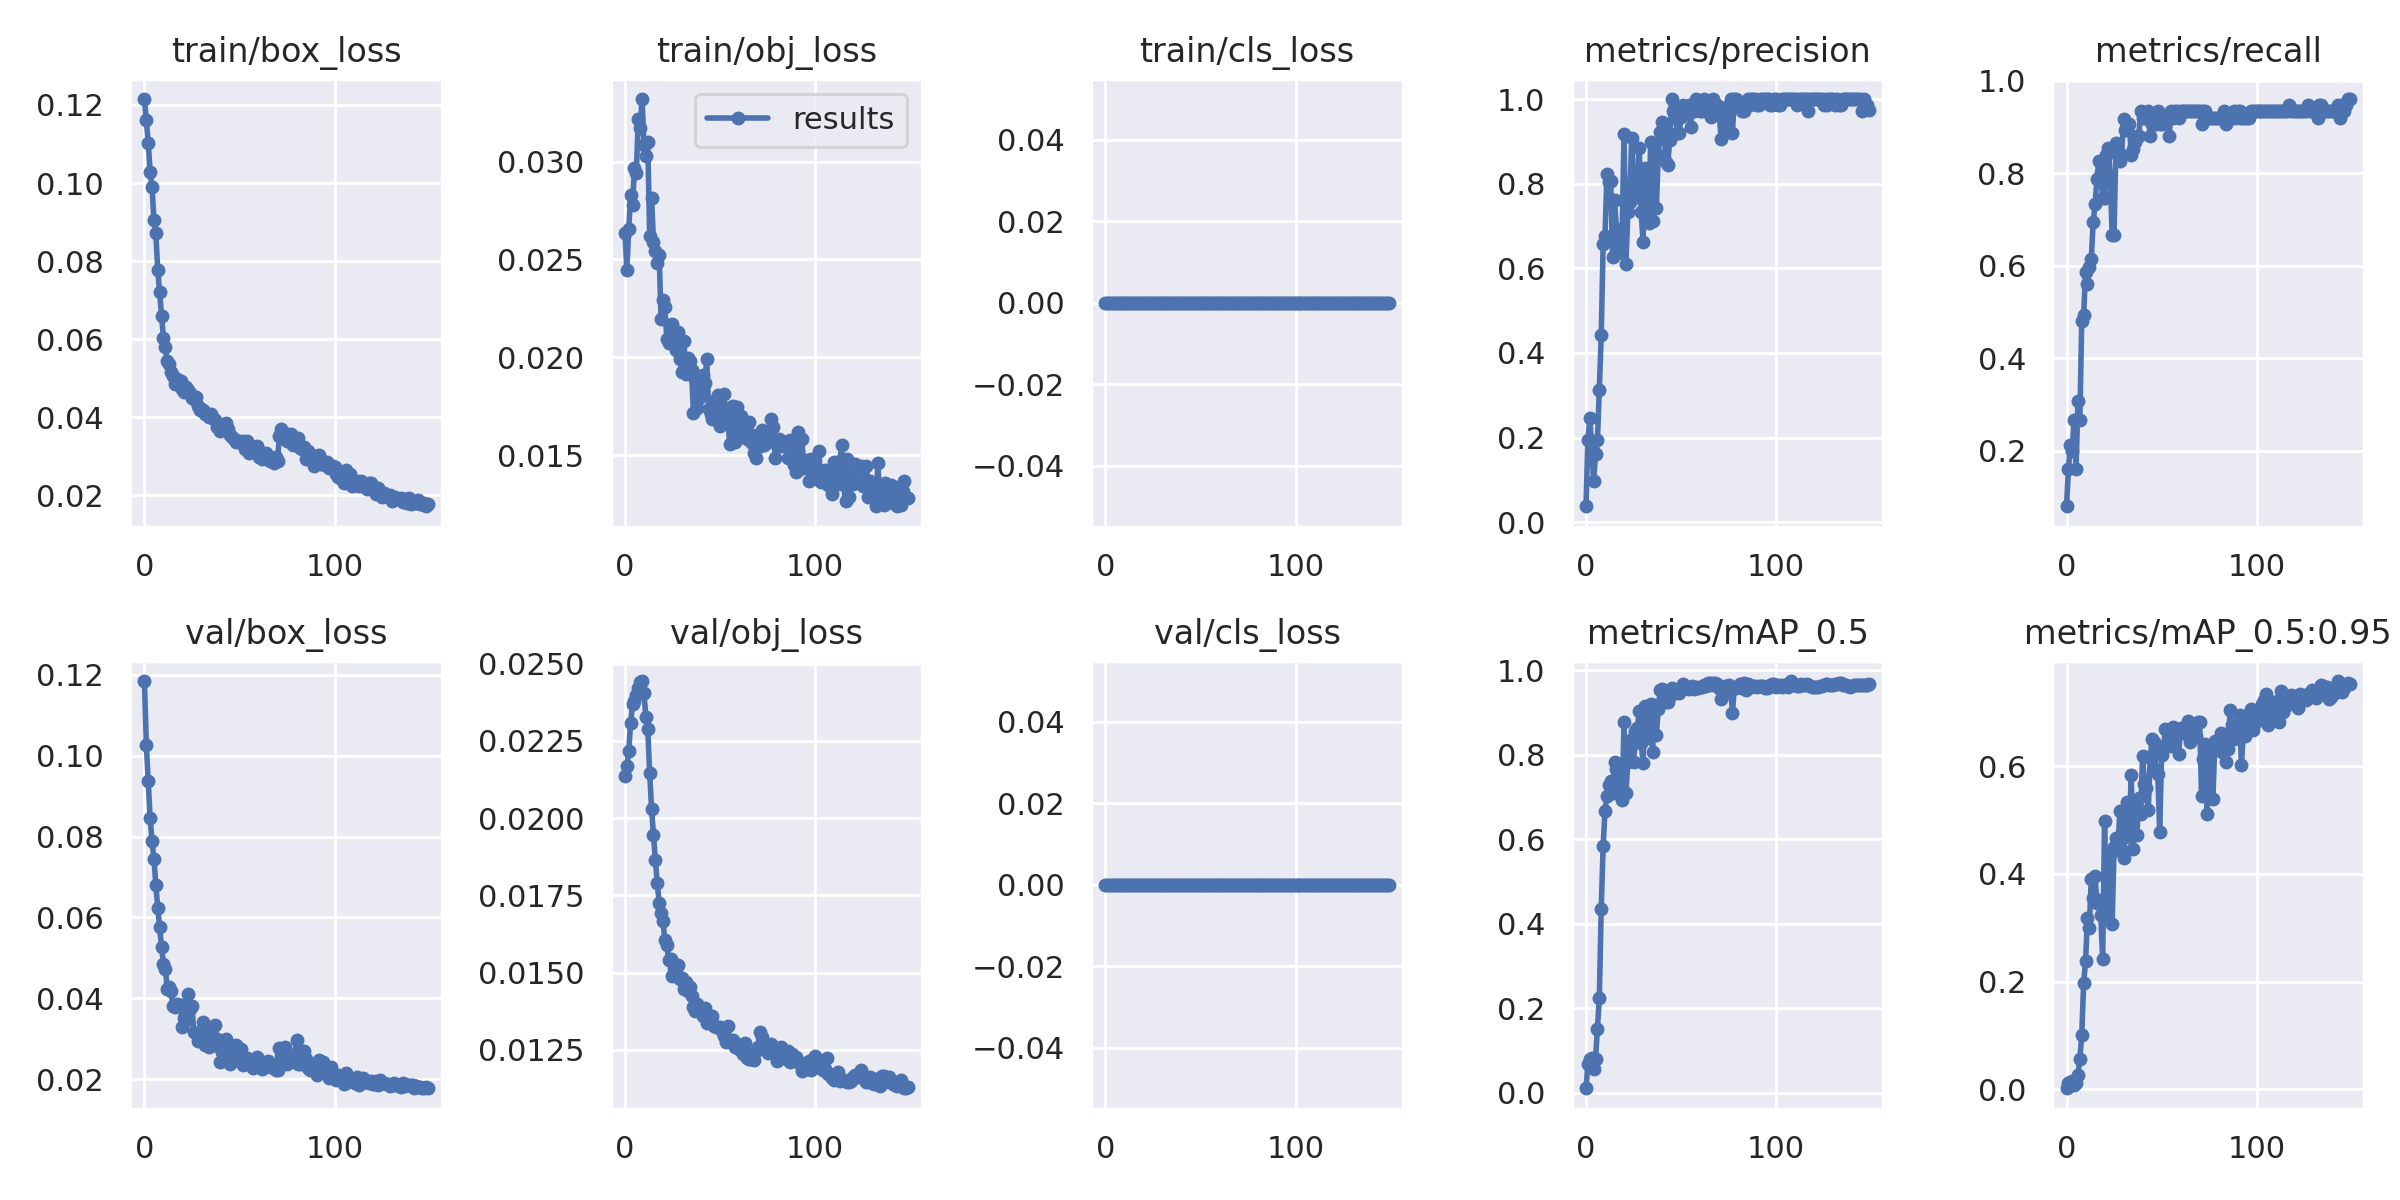

In [5]:
display.Image(f"runs_penguins/feature_extraction/results.png")

### <font color=003762>Fine Tuning

In [6]:
!python train.py --hyp 'hyp.finetune.yaml' --batch 16 --epochs 100 --data 'data/penguins_data.yaml' --weights 'runs_penguins/feature_extraction/weights/best.pt' --project 'runs_penguins' --name 'fine-tuning' --cache
clear_output()

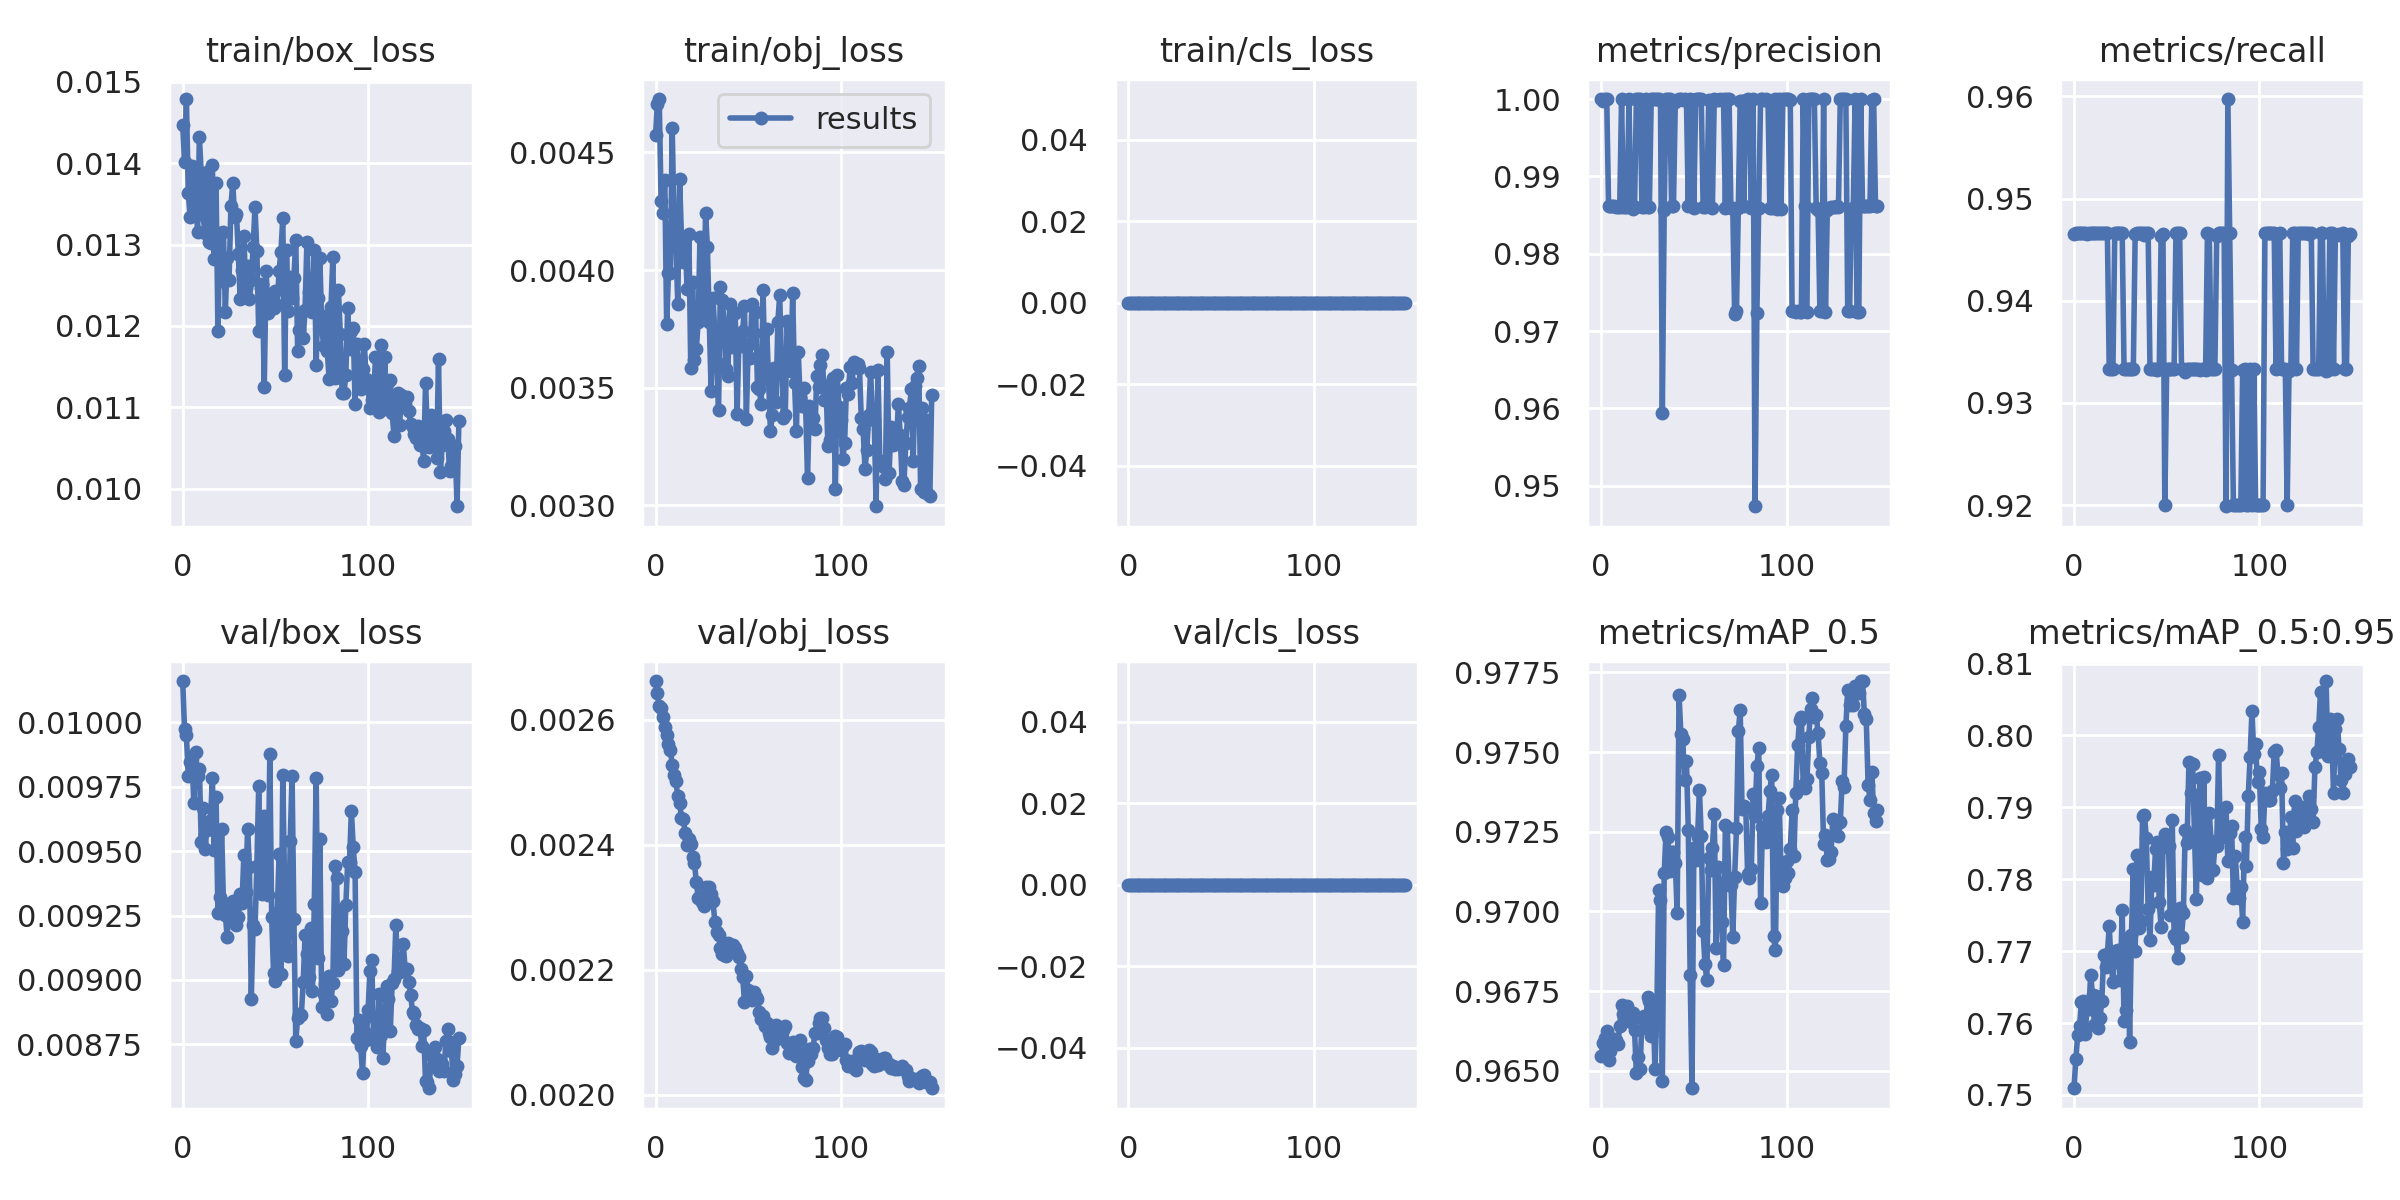

In [7]:
display.Image(f"runs_penguins/fine-tuning/results.png")

## <font color=2892A8>Validation</font>

In [8]:
!python val.py --weights 'runs_penguins/fine-tuning/weights/best.pt' --batch 64 --data 'data/penguins_data.yaml' --task test --project 'runs_penguins' --name 'validation_on_test_data' --augment
clear_output()

<font color=003762>Plot Precision Recall curve:

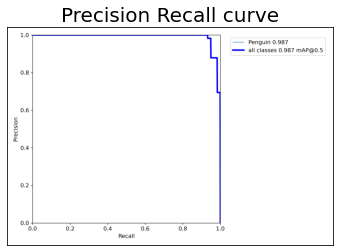

In [9]:
plt.plot(figsize=(20,20))
plt.title('Precision Recall curve', fontsize=20)
plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
plt.imshow(mpimg.imread('runs_penguins/validation_on_test_data/PR_curve.png'))


## <font color=2892A8>Inference</font>

In [10]:
!python detect.py --weights 'runs_penguins/fine-tuning/weights/best.pt'  --conf 0.6 --source '../datasets/Penguins_data/images/test' --project 'runs_penguins' --name 'detect_test' --augment --line=3
clear_output()

<font color=003762>View inference results:

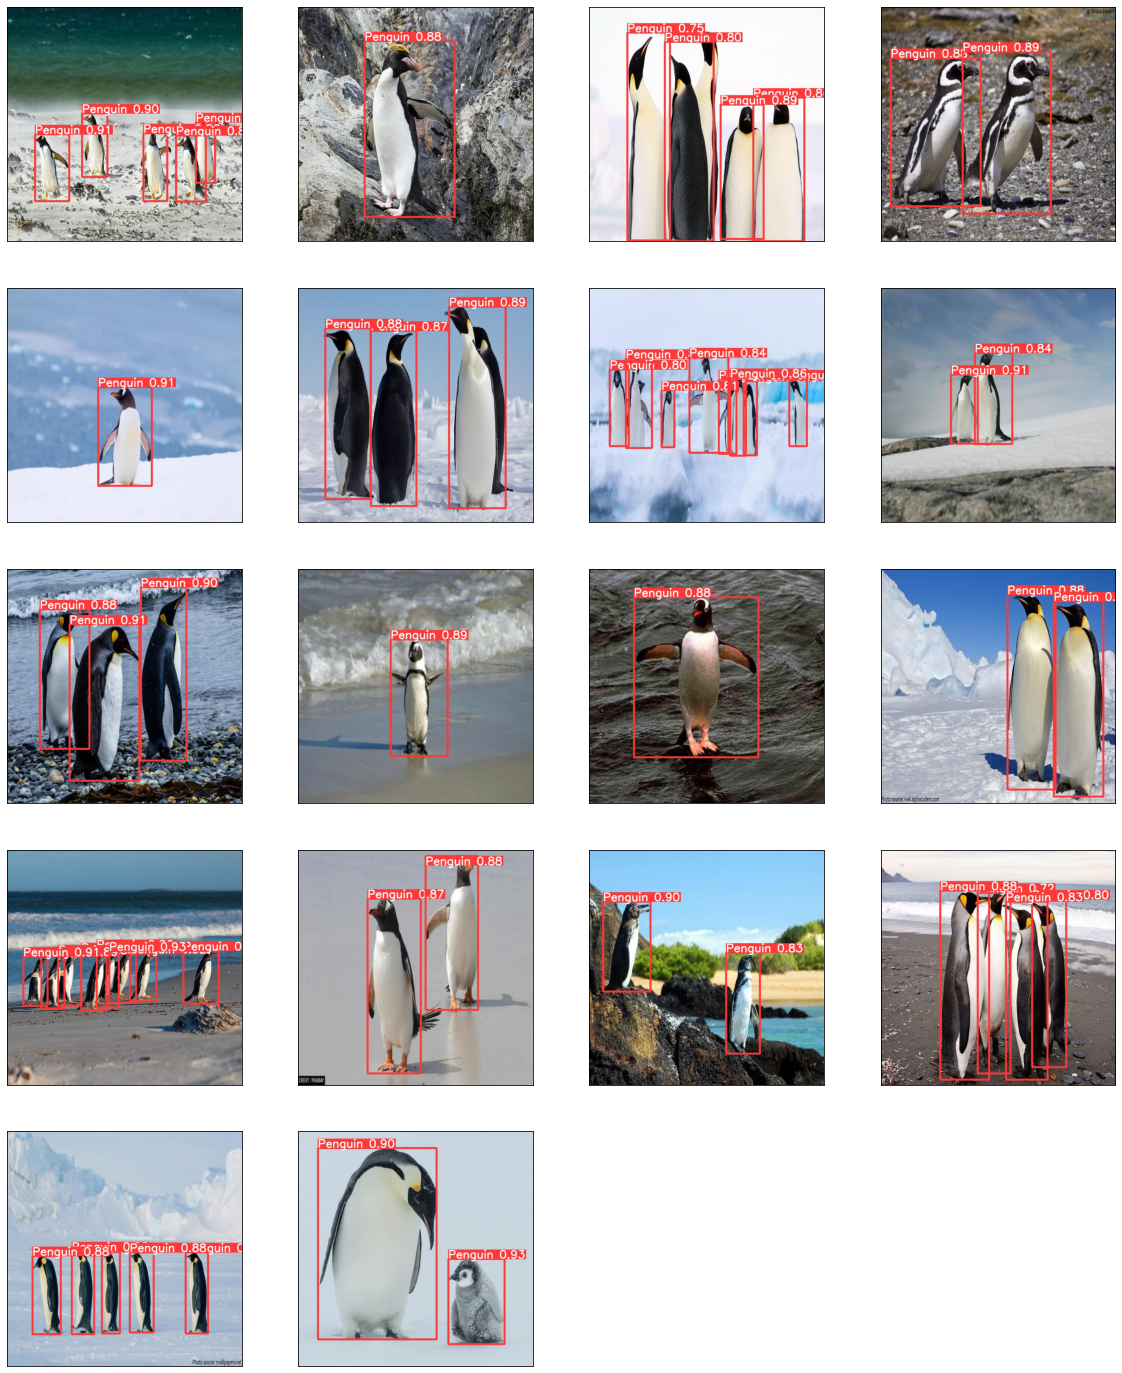

In [11]:
detect_path = r'runs_penguins/detect_test'

images = []
for img_path in glob.glob(detect_path + '/*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,25))
columns = 4
for i, image in enumerate(images):
    plt.subplot((int(len(images) / columns + 1)), columns, i + 1)
    plt.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    plt.imshow(image)

## <font color=2892A8>Converting model to ONNX & TensorRT</font>
<font color=003762>(Requires GPU)

<font color=003762>1. Install TensorRT

In [ ]:
# TensorRT 
# https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing-pip
!pip install -U nvidia-tensorrt --index-url https://pypi.ngc.nvidia.com  # install
clear_output()

<font color=003762>2. Export weights to ONNX format and to TensotRT engine

In [12]:
!python export.py --weights 'runs_penguins/fine-tuning/weights/best.pt' --include engine onnx --data 'data/penguins_data.yaml' --device 0 --imgsz 640 640
clear_output()